# MSc. Econometrics thesis Jupyter Notebook
# *Optimised Generalised Entropy Indices and Calibrated Post-Processing for Mitigating Unwanted Algorithmic Biases in Criminal Justice Risk Assessments*

## By Lennert Jansen

## Under the supervision of dr. Paul Bouman (EUR) & Benjamin Timmermans (IBM)

### Erasmus University Rotterdam, Erasmus School of Economics
### IBM, the Netherlands


#### Import statements

In [25]:
import numpy as np # for numerical methods, linear algebra, etc
import pandas as pd # for data wrangling
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for statistical data visualization
import statsmodels.formula.api as smf # for logistic regression
import statsmodels.api as sm # for statistical models
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# # AIF360 imports
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

## Functions made by me

In [26]:
def time_diff_to_float(from_date, to_date):
    """Convert date/time stamp strings into datetime types and return
    difference between dates in days (float)"""
    out = (pd.to_datetime(to_date) -  pd.to_datetime(from_date)) / pd._libs.tslibs.timedeltas.Timedelta(days = 1)
    return out

def categorical_var_dist(dataframe, variable_name):
    """Calculates the distribution of occurrences of a specified 
    categorical variable"""
    counts = dataframe[variable_name].value_counts()
    total = dataframe[variable_name].value_counts().sum()
    out = round((counts / total) * 100, 2)
    return out

def fix_column_names(dataframe):
    """Make column names of a dataframe usable for any function by making all
    letters lower case, trimming and replacing all spaces, hyphens and brackets
    with underscores"""
    
    dataframe.columns = dataframe.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('___', '_').str.replace('__', '_')
    
    return dataframe

def run_logit_model(dependent, independent, dataframe, intercept = True):
    """..."""
    
    # Fix names of variables and dataframe
    dependent = dependent.strip().lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace('___', '_').replace('__', '_')
    for string in independent:
        string = string.strip().lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_').replace('___', '_').replace('__', '_')
    dataframe = fix_column_names(dataframe)
    
    # Create dummy variables for categorical variables and remove reference
    # category from dataframe (i.e., the most represented category)
        
    return True



def write_to_tex_table(table):
    TABLE_LOCATION = '/Users/lennertjansen/Documents/Studie/Econometrie/master/thesis/scripts/recidivism/mytable.tex'
    
    with open(TABLE_LOCATION, 'w') as tf:
        tf.write(table.to_latex())


## Directories and figure size globals

In [27]:
# Figure directory
FIGURE_DIR ='/Users/lennertjansen/Documents/Studie/Econometrie/master/thesis/scripts/figures/recidivism/'


# Figure dimensions (A4 Dimensions)
FIG_DIM = (11.7, 8.27)

## Data preparations and exploratory data analyses

In [28]:
# Data import
# General recidivism data set (compas scores and two year recidivism)
raw_df = pd.read_csv("/Users/lennertjansen/Documents/Studie/Econometrie/master/thesis/scripts/data/compas/compas-scores-two-years.csv")
cross_table_sex_race_general_raw = pd.crosstab(raw_df.sex, raw_df.race, margins = True)


# Violent recidivism dataset
raw_violent_df = pd.read_csv("/Users/lennertjansen/Documents/Studie/Econometrie/master/thesis/scripts/data/compas/compas-scores-two-years-violent.csv")
cross_table_sex_race_violent_raw = pd.crosstab(raw_violent_df.sex, raw_violent_df.race, margins = True)

# Get dimensions
size = raw_df.shape

# Summary of basic columnwise statistics (like summary() in R)
summary = raw_df.describe()

# take a look at the first few rows
raw_df.head()

# test some simple plots
#raw_df['age'].plot()
#raw_df['age'].hist()

raw_df['race'].apply(len)

# Correlations and patter sclots
#corr_mat = raw_df.corr()

# corr_heatmap = sns.heatmap(corr_mat,
#             xticklabels = corr_mat.columns,
#             yticklabels = corr_mat.columns)



# Get column names as dataframe to convert to latex table
raw_df_colnames = raw_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('___', '_').str.replace('__', '_')

type(raw_df_colnames.values)
variable_descript_df = pd.DataFrame(raw_df_colnames.values,
                                    columns = ['Variable name'])
#print(variable_descript_df.to_latex())

##### DATA PREPARATION
# Methodology replication from original paper
# Based on: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb

# Select columns of interest
# general recidivism
df = raw_df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
             'priors_count', 'days_b_screening_arrest', 'decile_score',
             'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]

# violent recidivism
df_violent = raw_violent_df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
             'priors_count', 'days_b_screening_arrest', 'decile_score',
             'is_recid', 'two_year_recid', 'two_year_recid.1', 'c_jail_in', 'c_jail_out']]

# Filter out certain nonsensical values
# general recidivism
df = df[(df['days_b_screening_arrest'] <= 30) 
         & (df['days_b_screening_arrest'] >= -30) & (df['is_recid'] != -1) &
         (df['c_charge_degree'] != 'O') & (df['score_text'] != 'N/A')]

# violent recidivism
df_violent = df_violent[(df_violent['days_b_screening_arrest'] <= 30) 
         & (df_violent['days_b_screening_arrest'] >= -30) & (df_violent['is_recid'] != -1) &
         (df_violent['c_charge_degree'] != 'O') & (df_violent['score_text'] != 'N/A')]

df_violent.shape

# Add column with days spent in jail
# NOTE: remove negative values in this new column
df['length_of_stay'] = time_diff_to_float(df['c_jail_in'], df['c_jail_out'])

# Check for missing values
raw_df.isna().sum() 
df.isna().sum()

nrow = df.shape[0]
ncol = df.shape[1]


## Demographic Breakdown of both data sets (non-violent and violent recidivism)

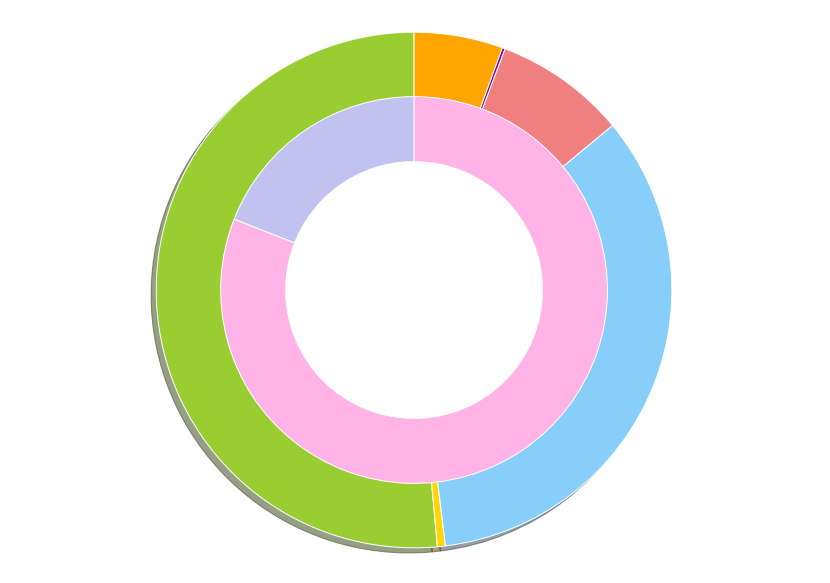

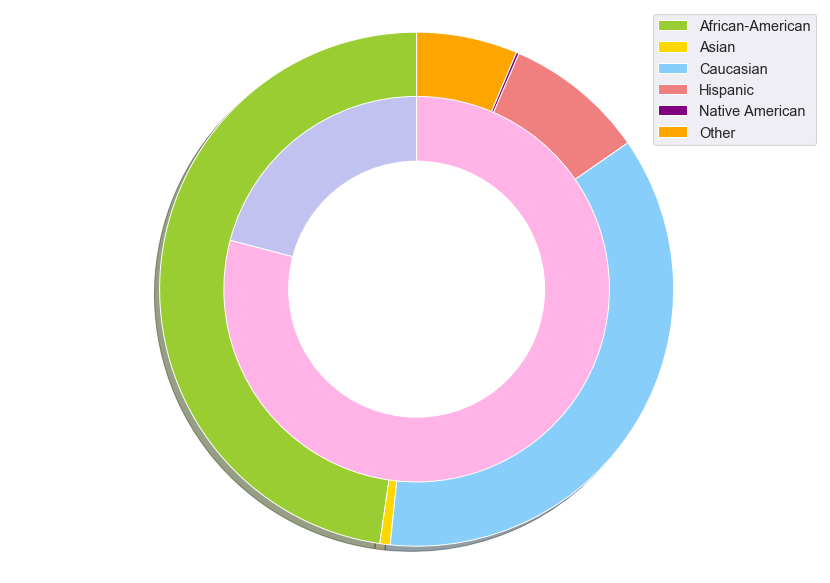

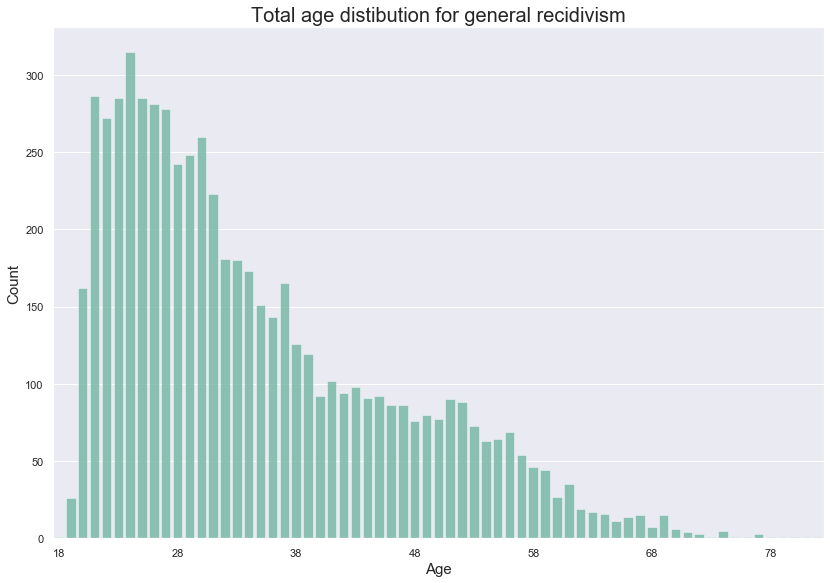

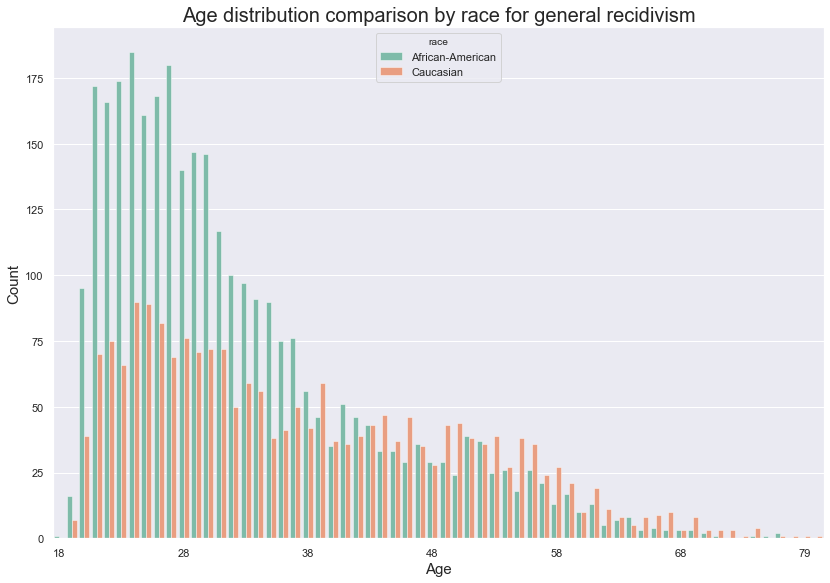

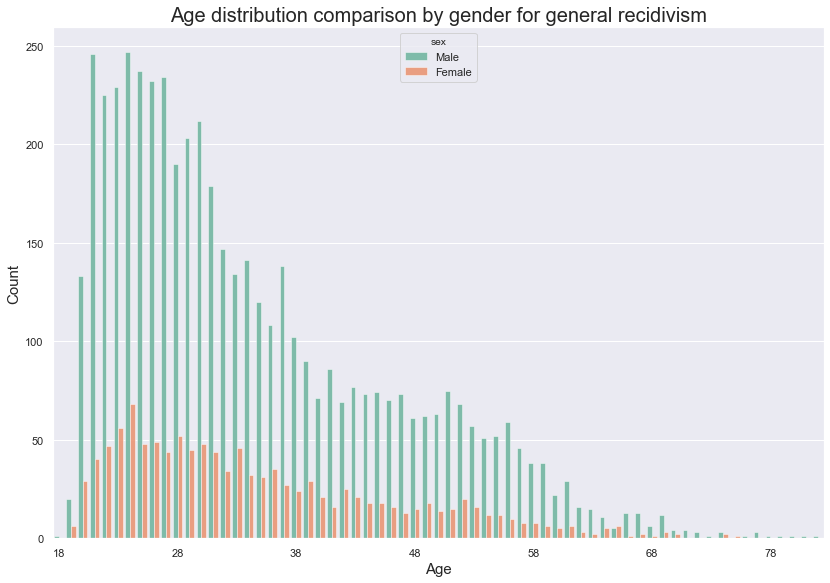

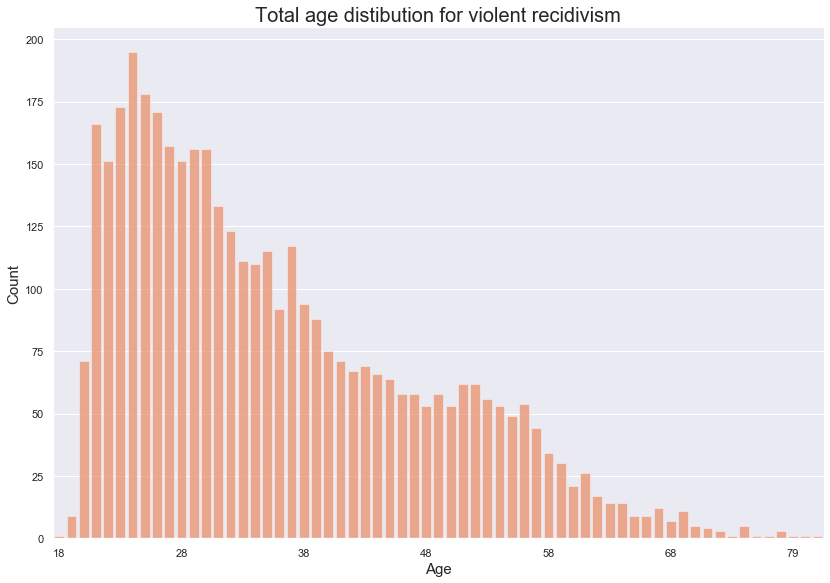

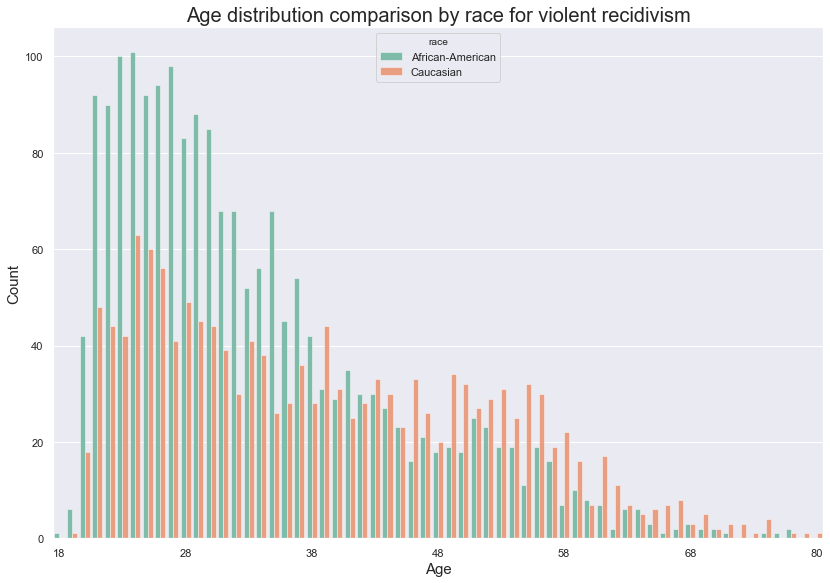

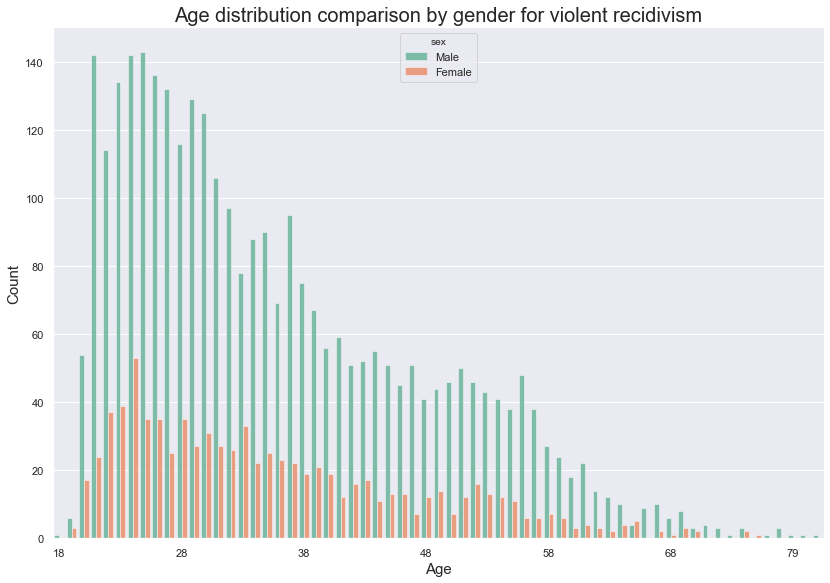

In [30]:
# Crosstables to LaTeX tables
# General
cross_table_general_sex_race = pd.crosstab(df.sex, df.race, margins = True)
write_to_tex_table(cross_table_general_sex_race)

# Violent
cross_table_violent_sex_race = pd.crosstab(df_violent.sex, df_violent.race, margins = True)
write_to_tex_table(cross_table_violent_sex_race)

# Corresponding Pie Charts
# Pie chart for general recidivism
# race
labels = list(cross_table_general_sex_race.columns)
del labels[-1] #delete last term from labels ("All")
#sizes = cross_table_general_sex_race.loc[["All"], labels].values
sizes = [3175,   31, 2103,  509,   11,  343]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'orange']

# gender
sizes_gender = [1175, 4997]
labels_gender = ['Female', 'Male']
colors_gender = ['#c2c2f0','#ffb3e6']

# Plot
# Outer donuts                
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)

# Inner donut
plt.pie(sizes_gender,colors=colors_gender,radius=0.75,startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
#plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()
#plt.figure.savefig(FIGURE_DIR + 'pie_demo_breakdown_general.png')


# Corresponding Pie Charts
# Pie chart for general recidivism
# race
labels_violent = list(cross_table_violent_sex_race.columns)
del labels_violent[-1] #delete last term from labels ("All")
#sizes_violent = cross_table_violent_sex_race.loc[["All"], labels].values
sizes_violent = [1918,   26, 1459,  355,    7,  255]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'purple', 'orange']

# gender
sizes_violent_gender = [841, 3179]
labels_gender = ['Female', 'Male']
colors_gender = ['#c2c2f0','#ffb3e6']

# Plot
# Outer donuts                
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
patches, texts = plt.pie(sizes_violent, colors=colors, shadow=True, startangle=90)

# Inner donut
plt.pie(sizes_violent_gender,colors=colors_gender,radius=0.75,startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(patches, labels, loc="best", prop={'size': 14.5})
plt.axis('equal')
plt.tight_layout()
plt.show()


# AGE DISTRIBUTIONS

#Color palette Set2 separate colors
Set2_green_rgb = (0.4, 0.7607843137254902, 0.6470588235294118)
Set2_orange_rgb = (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)

# GENERAL

# General: total
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_gen_age_total = sns.countplot(x = "age",
                                  data = df,
                                  color = Set2_green_rgb,
              linewidth = 0.5, alpha = 0.8)
hist_gen_age_total.set_title("Total age distibution for general recidivism",
                           size = 20)
hist_gen_age_total.set_ylabel("Count", size = 15)
hist_gen_age_total.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_gen_age_total.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_gen_age_total.figure.savefig(FIGURE_DIR + 'hist_gen_age_total.png')


# General: Caucasian vs African-American
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_gen_age_race = sns.countplot(x = "age",
                                  data = df[(df.race == 'African-American') | (df.race == 'Caucasian')],
                                  hue = "race", palette = "Set2",
              linewidth = 0.5, alpha = 0.9)
hist_gen_age_race.set_title("Age distribution comparison by race for general recidivism",
                           size = 20)
hist_gen_age_race.set_ylabel("Count", size = 15)
hist_gen_age_race.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_gen_age_race.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_gen_age_race.figure.savefig(FIGURE_DIR + 'hist_gen_age_race.png')


# General: Male vs Female
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_gen_age_sex = sns.countplot(x = "age", data = df, hue = "sex", palette = "Set2",
              linewidth = 0.5, alpha = 0.9)
hist_gen_age_sex.set_title("Age distribution comparison by gender for general recidivism",
                           size = 20)
hist_gen_age_sex.set_ylabel("Count", size = 15)
hist_gen_age_sex.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_gen_age_sex.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_gen_age_sex.figure.savefig(FIGURE_DIR + 'hist_gen_age_sex.png')


# VIOLENT
# Violent: total
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_vio_age_total = sns.countplot(x = "age",
                                  data = df_violent,
                                  color = Set2_orange_rgb,
              linewidth = 0.5, alpha = 0.8)
hist_vio_age_total.set_title("Total age distibution for violent recidivism",
                           size = 20)
hist_vio_age_total.set_ylabel("Count", size = 15)
hist_vio_age_total.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_vio_age_total.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_vio_age_total.figure.savefig(FIGURE_DIR + 'hist_vio_age_total.png')

# Violent: Caucasian vs African-American
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_vio_age_race = sns.countplot(x = "age",
                                  data = df_violent[(df_violent.race == 'African-American') | (df_violent.race == 'Caucasian')],
                                  hue = "race", palette = "Set2",
              linewidth = 0.5, alpha = 0.9)
hist_vio_age_race.set_title("Age distribution comparison by race for violent recidivism",
                           size = 20)
hist_vio_age_race.set_ylabel("Count", size = 15)
hist_vio_age_race.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_vio_age_race.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_vio_age_race.figure.savefig(FIGURE_DIR + 'hist_vio_age_race.png')


# Violent: Male vs Female
sns.set(style="darkgrid")
plt.figure(figsize = (FIG_DIM[0], FIG_DIM[1]))
hist_vio_age_sex = sns.countplot(x = "age", data = df_violent, hue = "sex", palette = "Set2",
              linewidth = 0.5, alpha = 0.9)
hist_vio_age_sex.set_title("Age distribution comparison by gender for violent recidivism",
                           size = 20)
hist_vio_age_sex.set_ylabel("Count", size = 15)
hist_vio_age_sex.set_xlabel("Age", size = 15)
# Decrease tick-frequency. Only show every 10th tick
for ind, label in enumerate(hist_vio_age_sex.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.tight_layout()
hist_vio_age_sex.figure.savefig(FIGURE_DIR + 'hist_vio_age_sex.png')
